In [1]:
!pip install svgwrite cairosvg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import svgwrite 
import cairosvg

In [7]:
def getPathXYs(inputFilePath):
    np_path_XYs = np.genfromtxt(inputFilePath , delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:] 
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY) 
        path_XYs.append(XYs)
    return path_XYs

In [3]:
def adjust_polygon_vertices(approx_polygon, num_sides):
    M = cv2.moments(approx_polygon)
    if M['m00'] == 0:
        M['m00'] = 1  
    center = (M['m10'] / M['m00'], M['m01'] / M['m00'])
    distances = [np.linalg.norm(np.array(vertex[0]) - np.array(center)) for vertex in approx_polygon]
    radius = np.mean(distances)
    angles = [np.arctan2(vertex[0][1] - center[1], vertex[0][0] - center[0]) for vertex in approx_polygon]
    sorted_vertices = sorted(zip(angles, approx_polygon), key=lambda x: x[0])
    adjusted_polygon = []
    for i, (angle, original_vertex) in enumerate(sorted_vertices):
        new_vertex = (
            int(center[0] + radius * np.cos(angle)),
            int(center[1] + radius * np.sin(angle))
        )
        adjusted_polygon.append(new_vertex)

    return np.array(adjusted_polygon, np.int32)


In [15]:
def processPNG(filePath, outputFilePath):
    image = cv2.imread(filePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (9, 9), 2)
    edges = cv2.Canny(blurred, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print("No contours found")
    else:
        largest_contour = max(contours, key=cv2.contourArea)
        image = cv2.polylines(image, [largest_contour], True, (255, 255, 255), 15)
        epsilon = 0.02 * cv2.arcLength(largest_contour, True)
        approx_polygon = cv2.approxPolyDP(largest_contour, epsilon, True)
        num_sides = len(approx_polygon)
        adjusted_polygon = adjust_polygon_vertices(approx_polygon, num_sides)
        adjusted_polygon = adjusted_polygon.reshape((-1, 1, 2))
        cv2.polylines(image, [adjusted_polygon], isClosed=True, color=(0, 0, 0), thickness=2)
        plt.axis('off')
        plt.imshow(image)
        plt.savefig(outputFilePath)


In [16]:
def regularizeImage(inputCSVPath, temporaryImagePath, outputFilePath):
    path_XYs = getPathXYs(inputCSVPath)
    plt.figure(figsize=(8,8))
    plt.axis('off')
    for i, XYs in enumerate(path_XYs):
        for XY in XYs:
            plt.plot(XY[:, 0], XY[:, 1], linewidth=2, c = (0,0,0))
    plt.savefig(f"{temporaryImagePath}/testFile.png")
    plt.clf()
    processPNG(f"{temporaryImagePath}/testFile.png", outputFilePath)

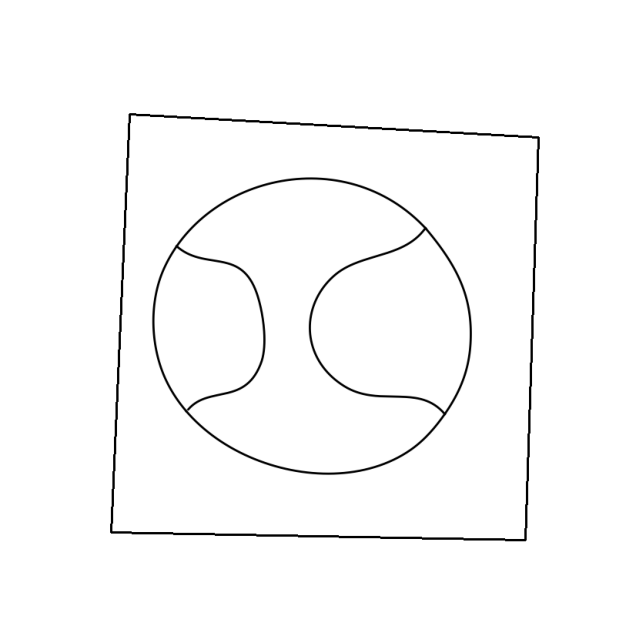

In [17]:
regularizeImage("/kaggle/input/adobe-gfg-dataset/frag0.csv",'/kaggle/working', '/kaggle/working/test2345.png')